### Урок 3. Generative adversarial networks (GAN): генеративные сети

__1. обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:__
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора

In [1]:
import numpy as np
import time

from torch.utils.data import DataLoader
import torch.nn as nn
import torch

import matplotlib.pyplot as plt

In [2]:
def func(x: np.array):
    return np.sin(x)/x - x/10

In [3]:
train_data_length = 1024

train_data = torch.zeros((train_data_length, 2))
xx = np.linspace(-10, 10, train_data_length)
train_data[:, 0] = torch.tensor(xx)
train_data[:, 1] = torch.tensor(func(xx))
train_labels = torch.ones(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)]

In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.model = nn.Sequential(
            *block(2, 16),
            *block(16, 32),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(0.3))
            return layers

        self.model = nn.Sequential(
            *block(2, 256),
            *block(256, 128),
            *block(128, 64),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
lr = 0.001
num_epochs = 400

generator = Generator()
discriminator = Discriminator()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

loss_function = torch.nn.BCELoss()

In [8]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_D.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_G.step()

        # Выводим значения функций потерь
        if (epoch + 1) % 50 == 0 and n == (batch_size - 1):
            print(f"Epoch: {epoch + 1} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch + 1} Loss G.: {loss_generator}")
            print("-"*40)

Epoch: 50 Loss D.: 0.5775666832923889
Epoch: 50 Loss G.: 1.006486177444458
----------------------------------------
Epoch: 100 Loss D.: 0.6807282567024231
Epoch: 100 Loss G.: 0.7346680164337158
----------------------------------------
Epoch: 150 Loss D.: 0.6787125468254089
Epoch: 150 Loss G.: 0.7444146275520325
----------------------------------------
Epoch: 200 Loss D.: 0.6307401657104492
Epoch: 200 Loss G.: 0.729630172252655
----------------------------------------
Epoch: 250 Loss D.: 0.7153431177139282
Epoch: 250 Loss G.: 0.7464126944541931
----------------------------------------
Epoch: 300 Loss D.: 0.6129003167152405
Epoch: 300 Loss G.: 0.8582574725151062
----------------------------------------
Epoch: 350 Loss D.: 0.6791574954986572
Epoch: 350 Loss G.: 0.7510126233100891
----------------------------------------
Epoch: 400 Loss D.: 0.7026802897453308
Epoch: 400 Loss G.: 0.7197780609130859
----------------------------------------


In [9]:
latent_space_samples = torch.randn(1024, 2)
generated_samples = generator(latent_space_samples)

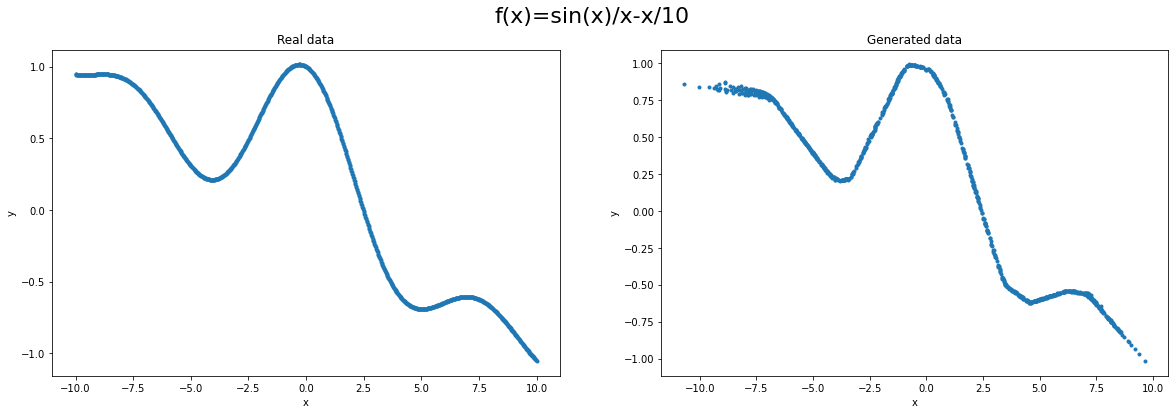

In [10]:
generated_samples = generated_samples.detach()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.plot(xx, func(xx), ".")
ax1.set_title("Real data")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
ax2.set_title("Generated data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.suptitle("f(x)=sin(x)/x-x/10", fontsize=22)
plt.show()

__2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.__

Источник: https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN/blob/master/pytorch_MNIST_DCGAN.py

In [11]:
import itertools
import pickle
import imageio
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from IPython import display
from torchvision.utils import save_image, make_grid

import warnings
warnings.filterwarnings("ignore")

In [12]:
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

In [13]:
n_epochs = 20
batch_size = 256
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 50

img_shape = (channels, img_size, img_size)

use_cuda = torch.cuda.is_available()
device = torch.device('cpu')

In [14]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

In [15]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

In [16]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(64), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [17]:
generator = Generator(16).to(device)
discriminator = Discriminator(16).to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [18]:
d_loss_history = []
g_loss_history = []

[Epoch 20/20] [Batch 185/235] [D loss: 4.526870] [G loss: 13.490562] (1:53:1 - (h:m:s))


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

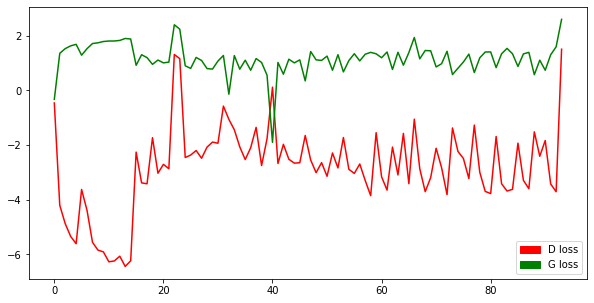

In [19]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim, 1, 1)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            total_time = time.gmtime(time.time() - start_time)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] (%d:%d:%d - (h:m:s))"% (epoch+1,
                                                                                                 n_epochs,
                                                                                                 i,
                                                                                                 len(real_data),
                                                                                                 d_loss.item(),
                                                                                                 g_loss.item(),
                                                                                                 total_time.tm_hour,
                                                                                                 total_time.tm_min,
                                                                                                 total_time.tm_sec)) 

            display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.figure(figsize=(10, 5))
            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red');
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green');
            plt.legend(handles=[red_patch, green_patch])
            plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


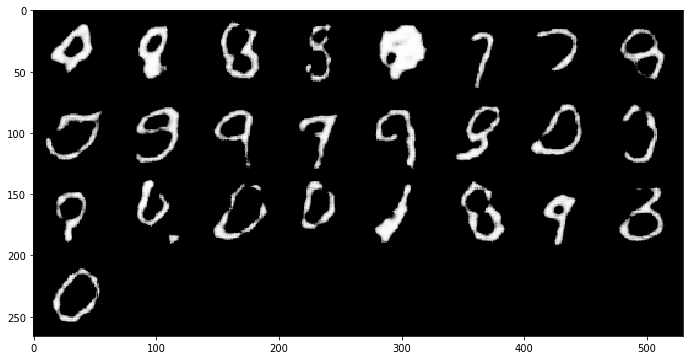

In [20]:
sample_image(generator(Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim, 1, 1))))))